# Regression diamond

In [118]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import joblib
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

# Считываем данные и выводим первые 5 строк

In [119]:
df = pd.read_csv('diamonds_train.csv')
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.51,Good,D,SI2,63.9,55.0,1180,5.04,5.10,3.24
1,0.72,Ideal,E,VS2,60.8,57.0,3091,5.79,5.82,3.53
2,0.70,Very Good,D,VVS2,62.8,60.0,4022,5.65,5.69,3.56
3,0.36,Ideal,D,SI1,61.2,57.0,663,4.59,4.63,2.82
4,0.54,Very Good,D,SI1,60.0,59.8,1593,5.30,5.34,3.18


# Выводим основную информацию о датасете

In [120]:
print("Информация о датасете: ")
df.info()

Информация о датасете: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43018 entries, 0 to 43017
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    43018 non-null  float64
 1   cut      43018 non-null  object 
 2   color    43018 non-null  object 
 3   clarity  43018 non-null  object 
 4   depth    43018 non-null  float64
 5   table    43018 non-null  float64
 6   price    43018 non-null  int64  
 7   x        43018 non-null  float64
 8   y        43018 non-null  float64
 9   z        43018 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.3+ MB


# Предварительная обработка данных и создание словаря из категориальных признаков

In [121]:

cut_map = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
color_map = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}
clarity_map = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}

df['cut_encoded'] = df['cut'].map(cut_map)
df['color_encoded'] = df['color'].map(color_map)
df['clarity_encoded'] = df['clarity'].map(clarity_map)

# Анализируем взаимосвязи признаков

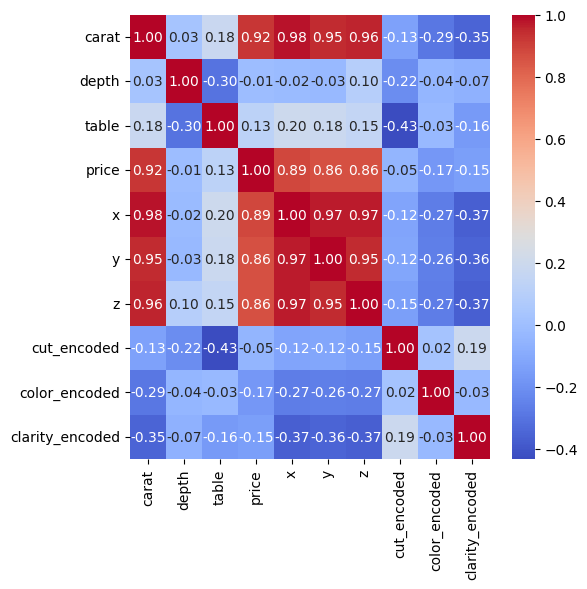

In [122]:
# Не преобразованные столбцы удаляю
df = df.drop(columns=['cut','clarity','color'], axis=1)

correlation_matrix = df.corr()

plt.figure(figsize=(6,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.tight_layout()
plt.show()

# Предварительная обработка данных и добавление нового признака (объема)

In [123]:
df = df.dropna()
missing = df.isnull().sum()
display(missing[missing > 0] if missing.sum() > 0 else "Пропущенных значений нет")
df = df[(df[['x', 'y', 'z']] != 0).all(axis=1)]
df['vol'] = df['x'] * df['y'] * df['z']
df = df.drop(['x','y','z'], axis=1)

'Пропущенных значений нет'

# Создание "треугольных" признаков

In [124]:

df['depth_per_table'] = df['depth'] / df['table']
df['density'] = df['carat'] / df['vol']

# Подготовка признаков

In [125]:
categorical_cols = ['cut', 'color', 'clarity']
for col in categorical_cols:
    if col in df.columns:
        print(f"{col}: {sorted(df[col].unique())}")
feature_columns = []
for col in df.columns:
    if col != 'price' and col not in categorical_cols:
        feature_columns.append(col)

print(f"Признаки для обучения ({len(feature_columns)}): {feature_columns}")
df.head()

Признаки для обучения (9): ['carat', 'depth', 'table', 'cut_encoded', 'color_encoded', 'clarity_encoded', 'vol', 'depth_per_table', 'density']


,carat,depth,table,price,cut_encoded,color_encoded,clarity_encoded,vol,depth_per_table,density
0,0.51,63.9,55.0,1180,1,6,1,83.280960,1.161818,0.006124
1,0.72,60.8,57.0,3091,4,5,3,118.953234,1.066667,0.006053
2,0.70,62.8,60.0,4022,2,6,5,114.448660,1.046667,0.006116
3,0.36,61.2,57.0,663,4,6,2,59.929794,1.073684,0.006007
4,0.54,60.0,59.8,1593,2,6,2,90.000360,1.003344,0.006000


# Подготавливаем X и y

In [126]:

X = df[feature_columns]
y = df['price']

print(f"Размеры: X {X.shape}, y {y.shape}")
print(f"Статистика цены - среднее: ${y.mean():,.2f}, медиана: ${y.median():,.2f}")

Размеры: X (43018, 9), y (43018,)
Статистика цены - среднее: $3,929.50, медиана: $2,401.00


# Разделение данных на три независимых набора для корректной оценки модели

In [127]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
X_train2, X_val, y_train2, y_val = train_test_split(
    X_train, y_train,
    test_size=0.25,
    random_state=42,
)



print(f"Train: {X_train.shape[0]:,} образцов ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test: {X_test.shape[0]:,} образцов ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Train2: {X_train2.shape[0]:,} образцов({X_train2.shape[0]/len(X)*100:.1f}%)")
print(f"Train2: {X_val.shape[0]:,} образцов({X_val.shape[0]/len(X)*100:.1f}%)")


Train: 34,414 образцов (80.0%)
Test: 8,604 образцов (20.0%)
Train2: 25,810 образцов(60.0%)
Train2: 8,604 образцов(20.0%)


# Создание и обучение модели валидации

In [128]:

final_model_val = Pipeline([
    ('minmax', MinMaxScaler()),
    ('standard', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])


In [129]:
final_model_val.fit(X_train, y_train)

Pipeline(steps=[('minmax', MinMaxScaler()), ('standard', StandardScaler()),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

# Получаем метрики для оценки
Делаем предсказания на валидационной части

In [130]:
y_val_pred = final_model_val.predict(X_val)
y_test_pred = final_model_val.predict(X_test)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)


print("Результаты на валидационной выборке")
print(f"R²: {val_r2:}")
print(f"MSE: ${val_mse:}")
print(f"RMSE: ${val_rmse:}")


Результаты на валидационной выборке
R²: 0.9974083929696654
MSE: $41455.31585138754
RMSE: $203.60578540745726


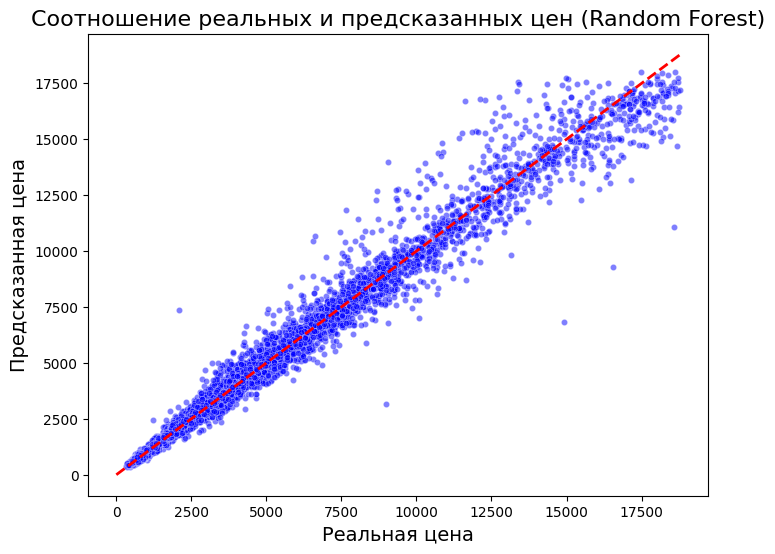

In [131]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.5, s=20, color='blue')
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Идеальный прогноз')

plt.xlabel("Реальная цена", fontsize=14)
plt.ylabel("Предсказанная цена", fontsize=14)
plt.title("Соотношение реальных и предсказанных цен (Random Forest)", fontsize=16)
plt.show()


# Обучение финальной модели на всех данных

In [132]:
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])
final_model.fit(X, y)
print("Финальная модель успешно обучена.")

Финальная модель успешно обучена.


# Сохраняем модель

In [133]:

joblib.dump(final_model, "final_model.pkl")

['final_model.pkl']

# Подготовка файла для отправки

In [134]:

df_test = pd.read_csv('diamonds_test.csv')

# Применение прошлых шагов предобработки

In [135]:
df_test['vol'] = df_test['x'] * df_test['y'] * df_test['z']
df_test['depth_per_table'] = df_test['depth'] / df_test['table']
df_test['density'] = df_test['carat'] / df_test['vol']
df_test['cut_encoded'] = df_test['cut'].map(cut_map)
df_test['color_encoded'] = df_test['color'].map(color_map)
df_test['clarity_encoded'] = df_test['clarity'].map(clarity_map)
df_test.fillna(0, inplace=True)

In [136]:
df.head()

,carat,depth,table,price,cut_encoded,color_encoded,clarity_encoded,vol,depth_per_table,density
0,0.51,63.9,55.0,1180,1,6,1,83.280960,1.161818,0.006124
1,0.72,60.8,57.0,3091,4,5,3,118.953234,1.066667,0.006053
2,0.70,62.8,60.0,4022,2,6,5,114.448660,1.046667,0.006116
3,0.36,61.2,57.0,663,4,6,2,59.929794,1.073684,0.006007
4,0.54,60.0,59.8,1593,2,6,2,90.000360,1.003344,0.006000


# Выбираем признаки

In [137]:
X_final_test = df_test[feature_columns]

# Предсказание с помощью финальной модели

In [138]:
predictions = final_model.predict(X_final_test)

# Сохранение результата

In [139]:
df_result = pd.DataFrame({'id': df_test['id'], 'price': predictions})
df_result.to_csv('submission.csv', index=False)